In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import xarray as xr

from dask.diagnostics import ProgressBar


from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import seaborn as sns

from skimage import measure

from nc_time_axis import CFTimeFormatter

from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.hovmoller import (
    compute_daily_anomalies, remove_rolling_mean,
    plot_hovmoller_by_lon,
)
from fme_diags.tropics.MJO_E3SM_util import get_MJO_signal
    
_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

In [2]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
ZERO_SHOT =  "fv3gfs_zero_shot-run01"

RUNS =  [FULL_RETRAINING, ZERO_SHOT]

In [3]:
config = load_config("./preds.yaml")
run_kwargs_dict = {
    run: get_run_kwargs(config, run)
    for run in RUNS
}

LAT_SLICE = slice(-15, 15)

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

In [4]:
OUTDIR = "figs/2024-05-12-hovmoller-1oyr"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds_dict = {
    run: open_autoregressive_inference(**run_kwargs)
    for run, run_kwargs in run_kwargs_dict.items()
}

In [6]:
da_hov = {}

for key, ds in ds_dict.items():
    da = ds['surface_precipitation_rate'].isel(sample=0) * PRECIP_FACTOR
    da.attrs["units"] = PRECIP_UNITS
    
    if key == ZERO_SHOT:
        da = da.sel(source="prediction")
        
    with ProgressBar():
        da = da.sel(lat=LAT_SLICE).resample(time="1D").mean("time").compute()
        
    if key == ZERO_SHOT:
        da = da.sel(lat=LAT_SLICE).mean("lat").rename({"init_time": "init"})
        da_hov["zero_shot"] = get_MJO_signal(da)
    else:
        da_pred = da.sel(source="prediction", lat=LAT_SLICE).mean("lat")
        da_tar = da.sel(source="target", lat=LAT_SLICE).mean("lat")
        da_hov["prediction"] = get_MJO_signal(da_pred)
        da_hov["target"] = get_MJO_signal(da_tar)
        
labels = {
    "zero_shot": "ACE-FV3GFS",
    "prediction": "ACE-EAMv2",
    "target": "EAMv2",
}
    
da_hov = xr.concat(
    list(da_hov.values()),
    dim="source",
).assign_coords({"source": list(da_hov.keys())}).assign_attrs(units=PRECIP_UNITS)

da_hov

[########################################] | 100% Completed | 42.7s
[########################################] | 100% Completed | 37.8s


<xarray.DataArray (source: 3, time: 3650, lon: 360)>
array([[[0.51110319, 0.51979338, 0.52846341, ..., 0.48519518,
         0.49377669, 0.50242166],
        [0.53684785, 0.5472682 , 0.55768949, ..., 0.50587192,
         0.51612282, 0.52645692],
        [0.54270282, 0.55497634, 0.56728087, ..., 0.50634197,
         0.51835939, 0.53048823],
        ...,
        [0.35002607, 0.35529924, 0.36053232, ..., 0.33425431,
         0.3394754 , 0.34474194],
        [0.41304753, 0.4190878 , 0.425089  , ..., 0.39497995,
         0.40096557, 0.40699731],
        [0.4684335 , 0.47563297, 0.4827994 , ..., 0.44692301,
         0.45405074, 0.46123001]],

       [[0.23394668, 0.24245869, 0.25064837, ..., 0.20680251,
         0.21608577, 0.22514479],
        [0.20372416, 0.21264264, 0.22132002, ..., 0.1758511 ,
         0.18529546, 0.19459745],
        [0.17908266, 0.18798145, 0.19671899, ..., 0.1517421 ,
         0.1609308 , 0.17005501],
...
        [0.32341697, 0.32821067, 0.33248473, ..., 0.30618639,
         0.31237722, 0.31813006],
        [0.2975233 , 0.3039259 , 0.3098619 , ..., 0.27581044,
         0.28343551, 0.29068324],
        [0.26645054, 0.27411492, 0.28138   , ..., 0.24137578,
         0.25004913, 0.25841806]],

       [[0.31309007, 0.30644469, 0.29954974, ..., 0.33143283,
         0.32559347, 0.31947615],
        [0.36059537, 0.35416364, 0.34740353, ..., 0.37781966,
         0.37243292, 0.3666884 ],
        [0.41214447, 0.40639942, 0.40024028, ..., 0.42680539,
         0.42235564, 0.41746607],
        ...,
        [0.21676454, 0.21130298, 0.20572531, ..., 0.23243668,
         0.22733316, 0.22210849],
        [0.23996293, 0.23392724, 0.22775227, ..., 0.25718456,
         0.25159669, 0.24585443],
        [0.27230057, 0.26582607, 0.2591668 , ..., 0.29053747,
         0.28466401, 0.27858247]]])
Coordinates:
  * time     (time) object 0054-01-01 00:00:00 ... 0063-12-31 00:00:00
    init     object 0054-01-01 00:00:00
  * source   (source) <U10 'prediction' 'target' 'zero_shot'
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    units:    mm/day

In [7]:
np.abs(da_hov).mean(["time", "lon"])

<xarray.DataArray (source: 3)>
array([0.56678683, 0.57738998, 0.50099465])
Coordinates:
    init     object 0054-01-01 00:00:00
  * source   (source) <U10 'prediction' 'target' 'zero_shot'
Attributes:
    units:    mm/day

In [8]:
np.abs(da_hov).max("lon").mean("time")

<xarray.DataArray (source: 3)>
array([1.4255666 , 1.42632757, 1.24477373])
Coordinates:
    init     object 0054-01-01 00:00:00
  * source   (source) <U10 'prediction' 'target' 'zero_shot'
Attributes:
    units:    mm/day

## Plot anomalies above the EAMv2 mean

In [9]:
thresh_mean = np.abs(da_hov.sel(source="target")).mean(["lon", "time"]).item()
da_hov_thresh_mean = xr.where(np.abs(da_hov) > thresh_mean, da_hov, 0.0)

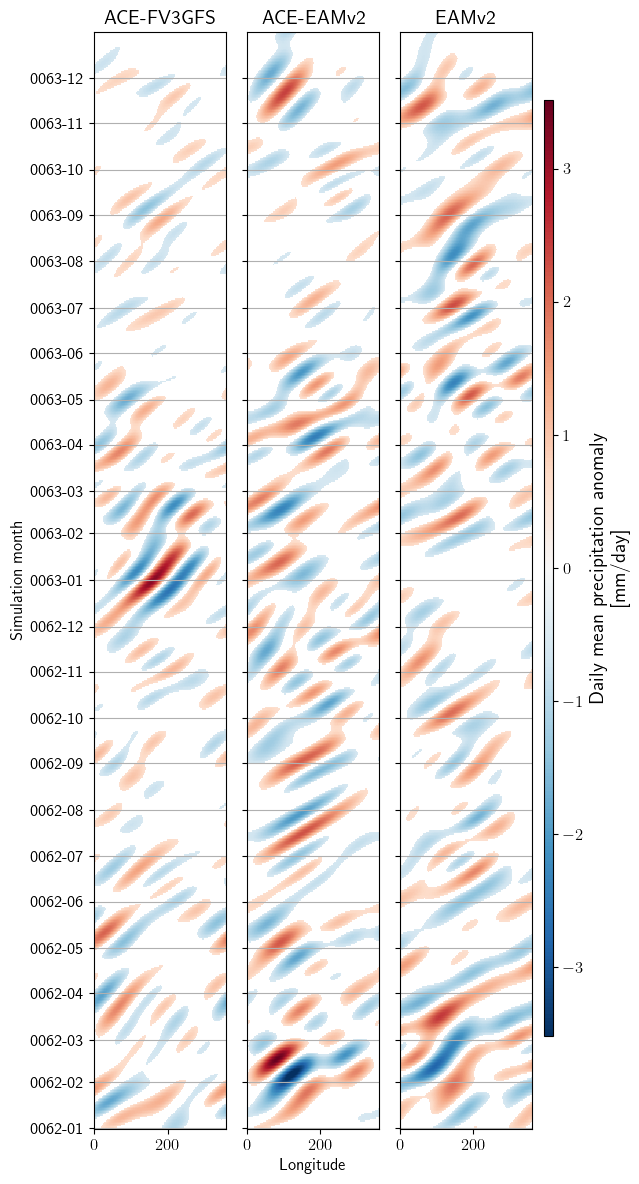

In [10]:
plt.rcParams.update({'font.size': 12})

da_to_plot = xr.where(da_hov_thresh_mean != 0.0, da_hov_thresh_mean, np.nan).isel(time=slice(-730, None))

vmax_abs = da_to_plot.max()

fig, axs = plot_hovmoller_by_lon(
    da_to_plot,
    var_name="precipitation anomaly",
    # figsize=(),
    time_label="Simulation month",
    labels=labels,
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_to_plot["time"][0].item(),
    da_to_plot["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))

for ax in axs:
    ax.grid(axis="y")

axs[0].set_xlabel("")
axs[2].set_xlabel("")

plt.show()

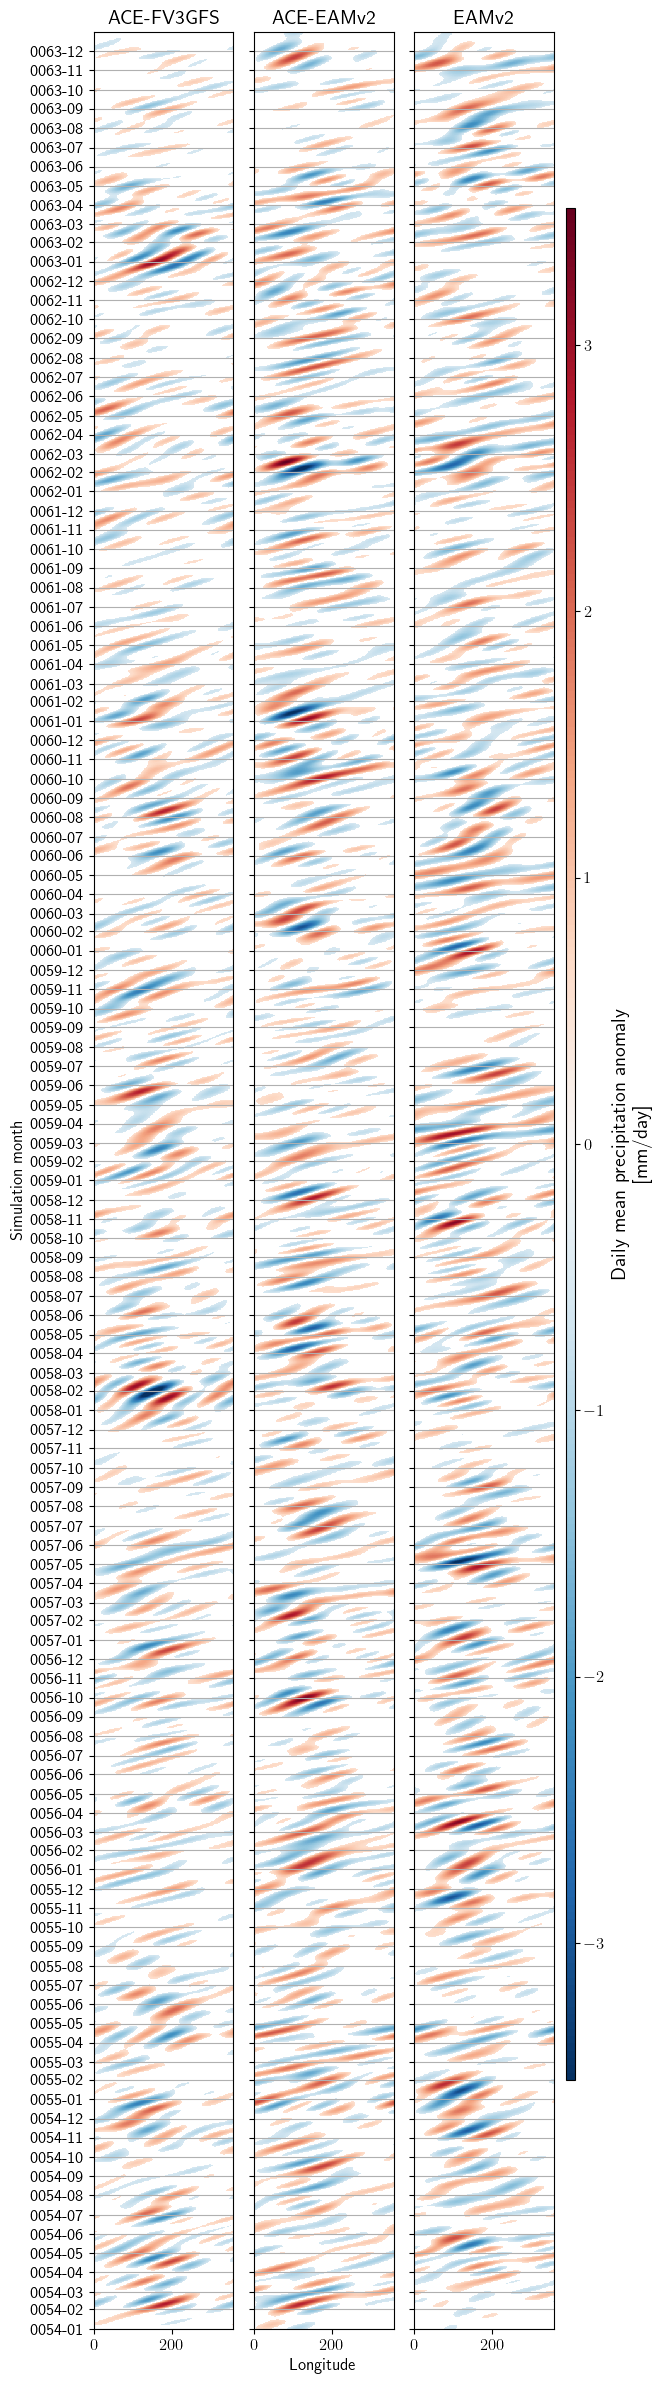

In [11]:
plt.rcParams.update({'font.size': 12})

da_to_plot = xr.where(da_hov_thresh_mean != 0.0, da_hov_thresh_mean, np.nan)

vmax_abs = da_to_plot.max()

fig, axs = plot_hovmoller_by_lon(
    da_to_plot,
    var_name="precipitation anomaly",
    figsize=(6, 24),
    time_label="Simulation month",
    labels=labels,
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_to_plot["time"][0].item(),
    da_to_plot["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))

for ax in axs:
    ax.grid(axis="y")

axs[0].set_xlabel("")
axs[2].set_xlabel("")

plt.show()

## Plot anomalies larger than the 90-th percentile of EAMv2

In [12]:
thresh = np.quantile(np.abs(da_hov.sel(source="target")).values, 0.9)
print(f"Threshhold: {thresh:.3f}")

da_hov_thresh = xr.where(np.abs(da_hov) > thresh, da_hov, 0.)

Threshhold: 1.237


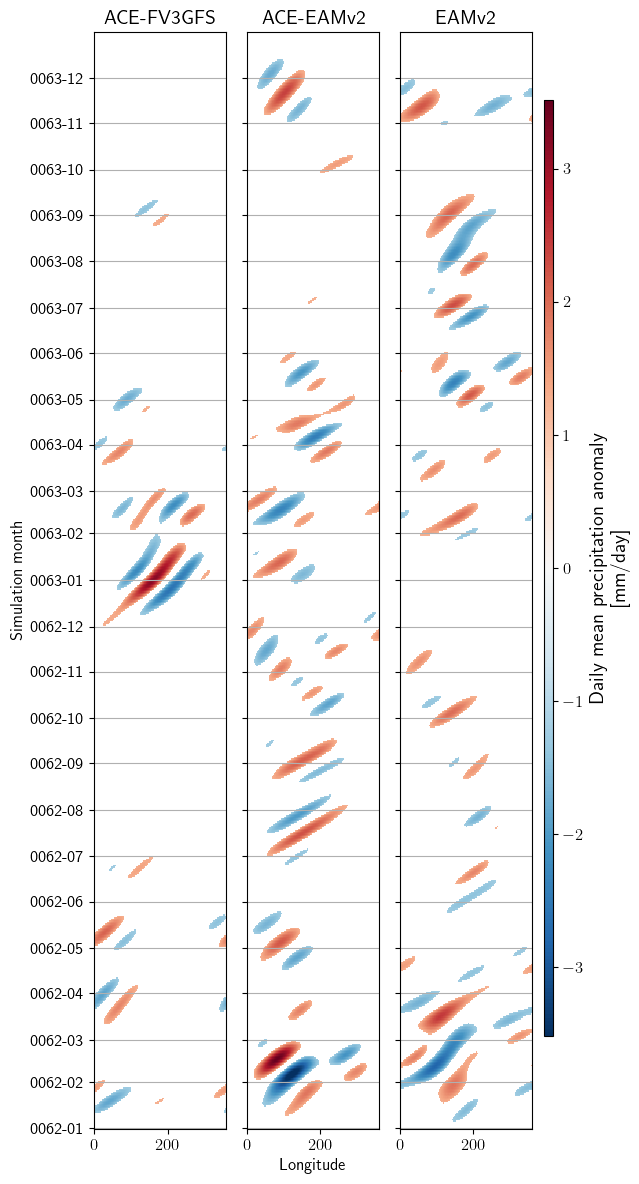

In [13]:
plt.rcParams.update({'font.size': 12})

da_to_plot = xr.where(da_hov_thresh != 0, da_hov_thresh, np.nan).isel(time=slice(-730, None))

vmax_abs = da_to_plot.max()

fig, axs = plot_hovmoller_by_lon(
    da_to_plot,
    var_name="precipitation anomaly",
    # figsize=(),
    time_label="Simulation month",
    labels=labels,
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_to_plot["time"][0].item(),
    da_to_plot["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))

for ax in axs:
    ax.grid(axis="y")

axs[0].set_xlabel("")
axs[2].set_xlabel("")

plt.show()

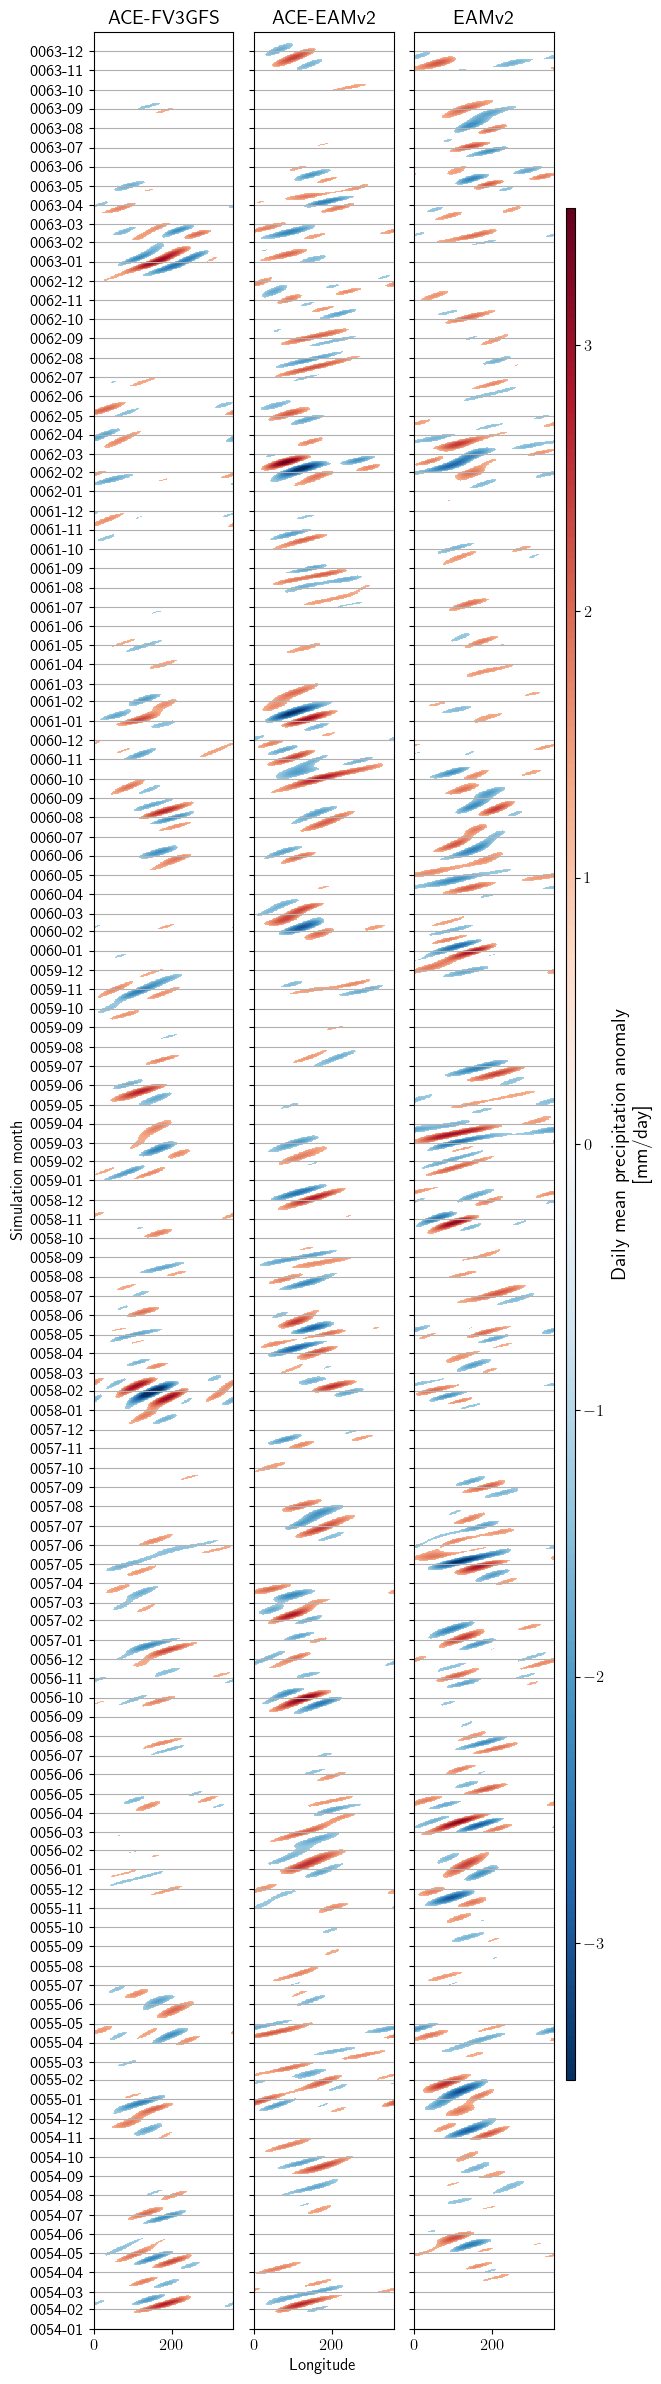

In [14]:
plt.rcParams.update({'font.size': 12})

da_to_plot = xr.where(da_hov_thresh != 0, da_hov_thresh, np.nan)
vmax_abs = da_to_plot.max()

fig, axs = plot_hovmoller_by_lon(
    da_to_plot,
    var_name="precipitation anomaly",
    figsize=(6, 24),
    time_label="Simulation month",
    labels=labels,
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_to_plot["time"][0].item(),
    da_to_plot["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))

for ax in axs:
    ax.grid(axis="y")

axs[0].set_xlabel("")
axs[2].set_xlabel("")

plt.show()

## Get anomaly properties for a range of thresholds

In [15]:
quantiles = [0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
mjo_props_df = []

props = [
    "label", "area", "axis_major_length",
    "intensity_mean", "intensity_max", "intensity_min",
]

for q in quantiles:
    thresh_q = np.quantile(np.abs(da_hov.sel(source="target")).values, q)
    da_hov_thresh = xr.where(np.abs(da_hov) > thresh_q, da_hov, 0.0)
    for source in da_hov["source"].values:
        img = da_hov_thresh.sel(source=source).values
        ccs, num_ccs = measure.label(
            img, 
            connectivity=2, background=0.0, return_num=True
        )
        df = pd.DataFrame(
            measure.regionprops_table(
                ccs, img,
                properties=props,
            )
        )
        df["source"] = labels[source]
        df["threshold"] = thresh_q
        df["threshold_quantile"] = q
        df["num_events"] = num_ccs
        mjo_props_df.append(df)

mjo_props_df = pd.concat(mjo_props_df)
mjo_props_df["event_type"] = np.where(mjo_props_df["intensity_mean"] > 0.0, "Wet", "Dry")
mjo_props_df["anomaly"] = np.abs(mjo_props_df["intensity_mean"])
mjo_props_df

,label,area,axis_major_length,intensity_mean,intensity_max,intensity_min,source,threshold,threshold_quantile,num_events,event_type,anomaly
0,1,1308.0,231.683313,1.445658,1.999874,1.000098,ACE-EAMv2,0.822894,0.75,332,Wet,1.445658
1,2,466.0,77.242396,-1.246661,-1.000372,-1.509051,ACE-EAMv2,0.822894,0.75,332,Dry,1.246661
2,3,591.0,101.303438,2.334221,2.701129,2.001476,ACE-EAMv2,0.822894,0.75,332,Wet,2.334221
3,4,1918.0,249.571886,-1.433887,-1.000356,-1.869379,ACE-EAMv2,0.822894,0.75,332,Dry,1.433887
4,5,430.0,73.664461,1.220625,1.442499,1.000961,ACE-EAMv2,0.822894,0.75,332,Wet,1.220625
...,...,...,...,...,...,...,...,...,...,...,...,...
122,123,87.0,29.015047,-1.566345,-1.518096,-1.614052,ACE-FV3GFS,1.517296,0.95,127,Dry,1.566345
123,124,143.0,43.972013,1.571476,1.636005,1.517995,ACE-FV3GFS,1.517296,0.95,127,Wet,1.571476
124,125,126.0,36.352151,-2.100486,-2.003590,-2.202897,ACE-FV3GFS,1.517296,0.95,127,Dry,2.100486
125,126,233.0,55.058641,1.624318,1.737478,1.518325,ACE-FV3GFS,1.517296,0.95,127,Wet,1.624318


In [44]:
group_cols = ["threshold_quantile", "event_type"]

eam_props_df = mjo_props_df[mjo_props_df["source"] == "EAMv2"].drop(["source", "label"], axis=1).groupby(group_cols).mean()
mean_props_df = mjo_props_df.drop("label", axis=1).groupby(group_cols + ["source"]).mean()

norm_props_df = mean_props_df.join(eam_props_df, rsuffix="_EAMv2")

for prop in props[1:] + ["anomaly", "num_events"]:
    norm_props_df[f"{prop}_norm"] = norm_props_df[prop] / norm_props_df[f"{prop}_EAMv2"]

norm_props_df

area  axis_major_length  \
threshold_quantile event_type source                                      
0.750              Dry        ACE-EAMv2   610.681250          88.402855   
                              ACE-FV3GFS  526.626761          77.460925   
                              EAMv2       618.039773          91.819329   
                   Wet        ACE-EAMv2   640.395349          93.848122   
                              ACE-FV3GFS  519.947020          76.218269   
                              EAMv2       688.502924          95.865463   
0.775              Dry        ACE-EAMv2   610.681250          88.402855   
                              ACE-FV3GFS  526.626761          77.460925   
                              EAMv2       618.039773          91.819329   
                   Wet        ACE-EAMv2   640.395349          93.848122   
                              ACE-FV3GFS  519.947020          76.218269   
                              EAMv2       688.502924          95.865463   
0.800              Dry        ACE-EAMv2   610.681250          88.402855   
                              ACE-FV3GFS  526.626761          77.460925   
                              EAMv2       618.039773          91.819329   
                   Wet        ACE-EAMv2   640.395349          93.848122   
                              ACE-FV3GFS  519.947020          76.218269   
                              EAMv2       688.502924          95.865463   
0.825              Dry        ACE-EAMv2   610.681250          88.402855   
                              ACE-FV3GFS  526.626761          77.460925   
                              EAMv2       618.039773          91.819329   
                   Wet        ACE-EAMv2   640.395349          93.848122   
                              ACE-FV3GFS  519.947020          76.218269   
                              EAMv2       688.502924          95.865463   
0.850              Dry        ACE-EAMv2   564.073333          85.030395   
                              ACE-FV3GFS  474.398496          72.430437   
                              EAMv2       557.230769          87.152145   
                   Wet        ACE-EAMv2   629.574194          95.716439   
                              ACE-FV3GFS  494.807407          74.381925   
                              EAMv2       620.048193          89.867148   
0.875              Dry        ACE-EAMv2   523.865672          81.694844   
                              ACE-FV3GFS  448.754386          72.716515   
                              EAMv2       496.762821          82.217667   
                   Wet        ACE-EAMv2   600.628571          96.949533   
                              ACE-FV3GFS  458.546218          72.534383   
                              EAMv2       582.248322          89.708928   
0.900              Dry        ACE-EAMv2   517.436364          84.877815   
                              ACE-FV3GFS  404.857143          70.516647   
                              EAMv2       447.284672          79.732082   
                   Wet        ACE-EAMv2   539.107692          93.983322   
                              ACE-FV3GFS  424.560000          71.679120   
                              EAMv2       483.600000          81.457369   
0.925              Dry        ACE-EAMv2   453.895833          82.437674   
                              ACE-FV3GFS  342.277108          67.309494   
                              EAMv2       408.017857          78.840516   
                   Wet        ACE-EAMv2   452.729508          87.321845   
                              ACE-FV3GFS  368.829268          67.727038   
                              EAMv2       406.553846          76.385839   
0.950              Dry        ACE-EAMv2   328.766667          71.879910   
                              ACE-FV3GFS  302.898305          66.417117   
                              EAMv2       311.580000          69.034577   
                   Wet        ACE-EAMv2   337.912281          76.554851  

/tmp/ipykernel_930299/393295612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot["anomaly_norm_sq"] = df_to_plot["anomaly_norm"] ** 2


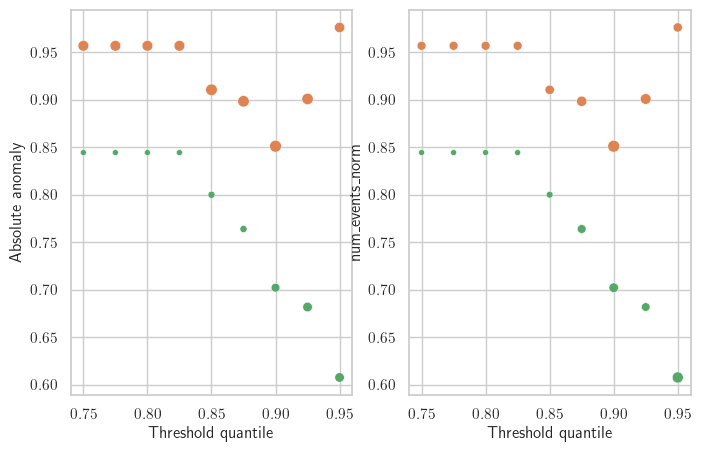

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

df_to_plot = norm_props_df.loc[
    norm_props_df.index.get_level_values("source") != "EAMv2"
]

df_to_plot["anomaly_norm_sq"] = df_to_plot["anomaly_norm"] ** 2

_ = sns.scatterplot(
    df_to_plot.loc[df_to_plot.index.get_level_values("event_type") == "Wet"], 
    x="threshold_quantile",
    y="num_events_norm", 
    hue="source",
    size="anomaly_norm_sq",
    hue_order=list(reversed(labels.values())),
    markers=True,
    ax=axs[0],
    legend=False,
)

_ = sns.scatterplot(
    df_to_plot.loc[df_to_plot.index.get_level_values("event_type") == "Dry"], 
    x="threshold_quantile",
    y="num_events_norm", 
    hue="source",
    size="anomaly_norm_sq",
    hue_order=list(reversed(labels.values())),
    markers=True,
    ax=axs[1],
    legend=False,
)

# legend = axs[1].legend()
# legend.texts[0].set_text(None)
# legend.texts[3].set_text(legend.texts[3].get_text() + "\n")
# legend.texts[4].set_text("Number of\nMJO events:")
# sns.move_legend(axs[1], "upper left")
axs[0].set_ylabel("Absolute anomaly")


for ax in axs:
    ax.set_xlabel("Threshold quantile")
    ax.grid("both")
    # ax.set_ylim((0.935, 1.065))

plt.show()

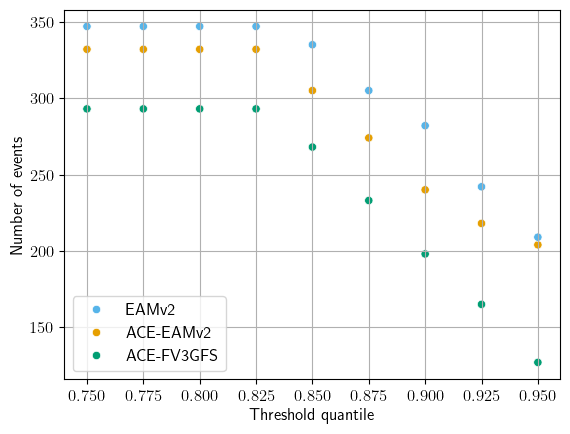

In [16]:
cols = ["threshold_quantile", "num_events", "source"]

num_mjo_df = mjo_props_df[cols].drop_duplicates()

ax = sns.scatterplot(
    num_mjo_df, 
    x="threshold_quantile",
    y="num_events", 
    hue="source",
    hue_order=list(reversed(labels.values())),
    markers=True,
)
legend = ax.legend()
sns.move_legend(ax, "lower left")
ax.set_ylabel("Number of events")
ax.set_xlabel("Threshold quantile")
plt.grid()
plt.show()

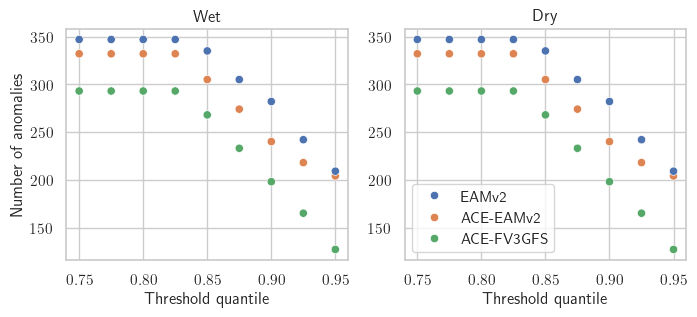

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

cols = ["event_type", "num_events", "threshold_quantile", "source"]

df_to_plot = mjo_props_df[cols].groupby(["event_type", "threshold_quantile", "source"]).mean()

_ = sns.scatterplot(
    df_to_plot.loc[df_to_plot.index.get_level_values("event_type") == "Wet"], 
    x="threshold_quantile",
    y="num_events", 
    hue="source",
    hue_order=list(reversed(labels.values())),
    markers=True,
    ax=axs[0],
    legend=False
)

_ = sns.scatterplot(
    df_to_plot.loc[df_to_plot.index.get_level_values("event_type") == "Dry"], 
    x="threshold_quantile",
    y="num_events", 
    hue="source",
    hue_order=list(reversed(labels.values())),
    markers=True,
    ax=axs[1],
)

legend = axs[1].legend()
# legend.texts[0].set_text(None)
# legend.texts[3].set_text(legend.texts[3].get_text() + "\n")

# legend.texts[4].set_text("Number of\nMJO events:")
# sns.move_legend(ax, "upper left")

axs[0].set_ylabel("Number of anomalies")
axs[0].set_title("Wet")

axs[1].set_ylabel("")
axs[1].set_title("Dry")

for ax in axs:
    ax.grid("both")
    ax.set_xlabel("Threshold quantile")

plt.show()

In [71]:
fig.savefig(os.path.join(OUTDIR, "hov_anomalies.pdf"), bbox_inches="tight")

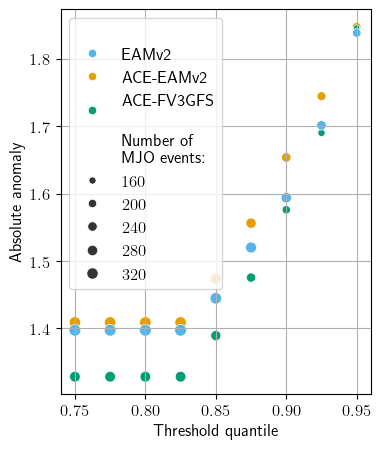

In [17]:
fig, ax = plt.subplots(figsize=(4,5))

cols = ["anomaly", "num_events", "threshold_quantile", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean()

ax = sns.scatterplot(
    df_to_plot, 
    x="threshold_quantile",
    y="anomaly", 
    hue="source",
    size="num_events",
    hue_order=list(reversed(labels.values())),
    markers=True,
    ax=ax,
)
legend = ax.legend()
legend.texts[0].set_text(None)
legend.texts[3].set_text(legend.texts[3].get_text() + "\n")
legend.texts[4].set_text("Number of\nMJO events:")
sns.move_legend(ax, "upper left")
ax.set_ylabel("Absolute anomaly")
ax.set_xlabel("Threshold quantile")

ax.grid("both")
plt.show()

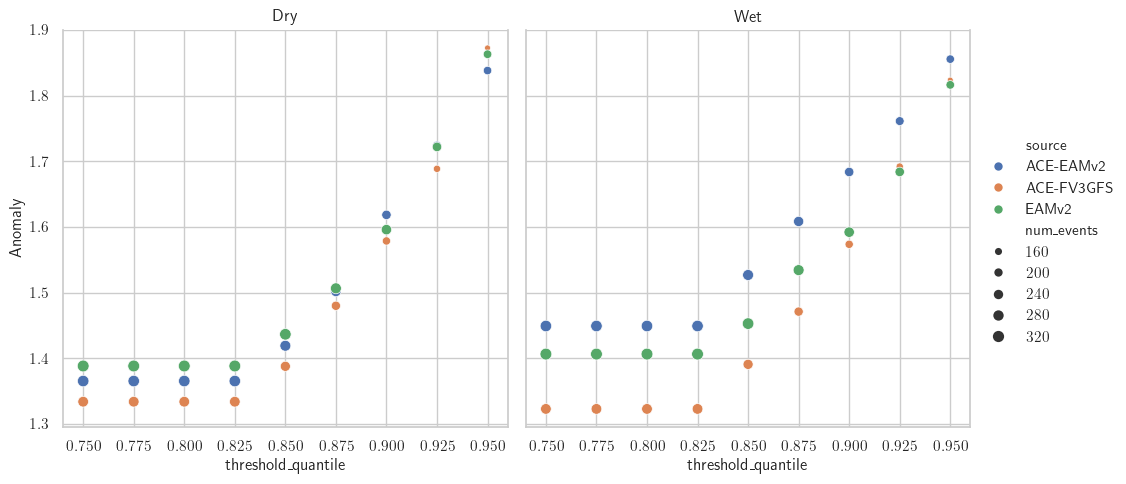

In [335]:
cols = ["event_type", "anomaly", "num_events", "threshold_quantile", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source", "event_type"]).mean()

sns.set_theme()
sns.set_style("whitegrid")
g = sns.relplot(
    data=df_to_plot, 
    x="threshold_quantile", 
    y="anomaly", 
    hue="source",
    col="event_type",
    size="num_events",
    kind="scatter", 
)
g.despine(right=False)
g.set_titles(col_template="{col_name}")
axs = g.axes.flatten()

axs[0].set_ylabel("Anomaly")

plt.show()

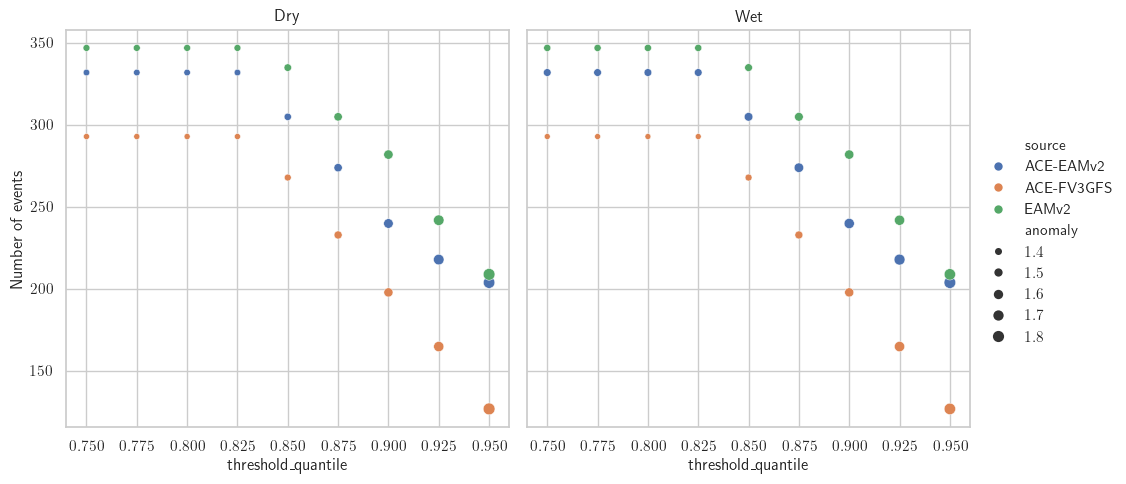

In [20]:
# cols = ["event_type", "anomaly", "num_events", "threshold_quantile", "source"]

cols = ["event_type", "anomaly", "threshold_quantile", "num_events", "source"]
df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source", "event_type"]).mean()

sns.set_theme()
sns.set_style("whitegrid")
g = sns.relplot(
    data=df_to_plot, 
    x="threshold_quantile", 
    y="num_events", 
    hue="source",
    size="anomaly",
    col="event_type",
    kind="scatter", 
)
g.despine(right=False, top=False)
g.set_titles(col_template="{col_name}")
axs = g.axes.flatten()

axs[0].set_ylabel("Number of events")

plt.show()

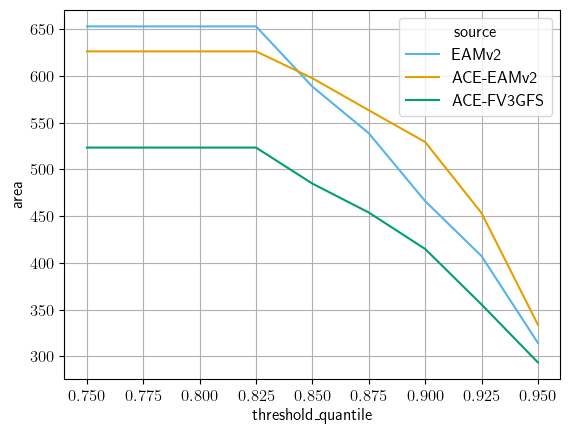

In [281]:
cols = ["threshold_quantile", "area", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean("area")
sns.lineplot(df_to_plot, x="threshold_quantile", y="area", hue="source", hue_order=list(reversed(labels.values())))
plt.grid()
plt.show()

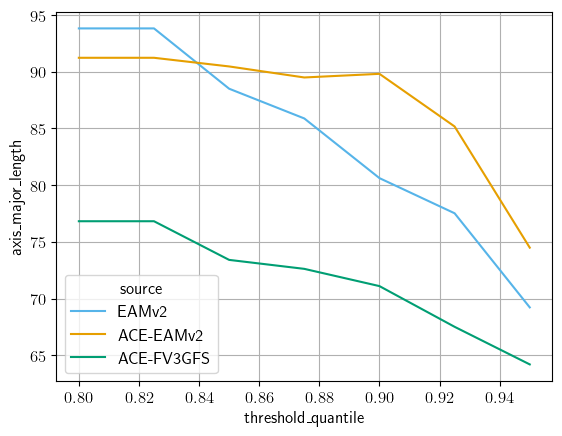

In [278]:
cols = ["threshold_quantile", "axis_major_length", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean("axis_major_length")
sns.lineplot(df_to_plot, x="threshold_quantile", y="axis_major_length", hue="source", hue_order=list(reversed(labels.values())))
plt.grid()
plt.show()

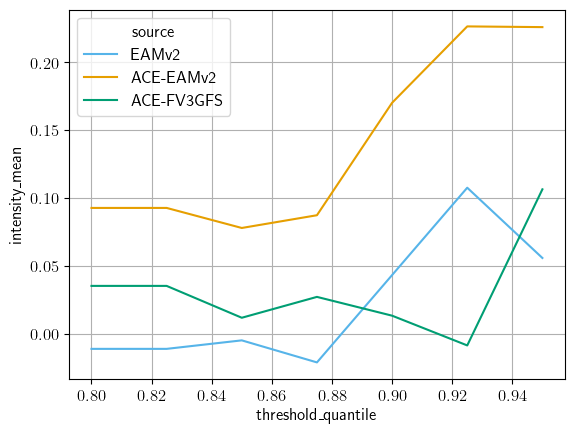

In [277]:
cols = ["threshold_quantile", "intensity_mean", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean("intensity_mean")
sns.lineplot(df_to_plot, x="threshold_quantile", y="intensity_mean", hue="source", hue_order=list(reversed(labels.values())))
plt.grid()
plt.show()

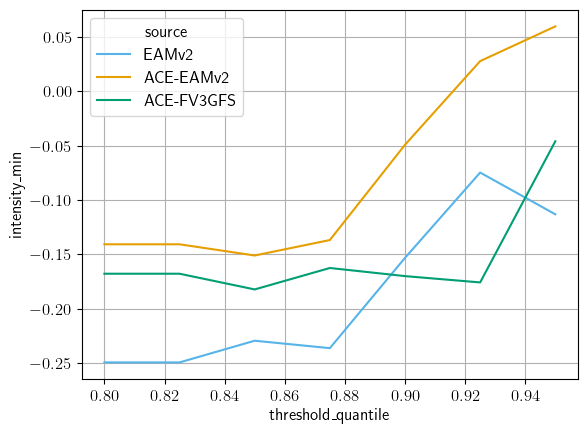

In [276]:
cols = ["threshold_quantile", "intensity_min", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean("intensity_min")
sns.lineplot(df_to_plot, x="threshold_quantile", y="intensity_min", hue="source", hue_order=list(reversed(labels.values())))
plt.grid()
plt.show()

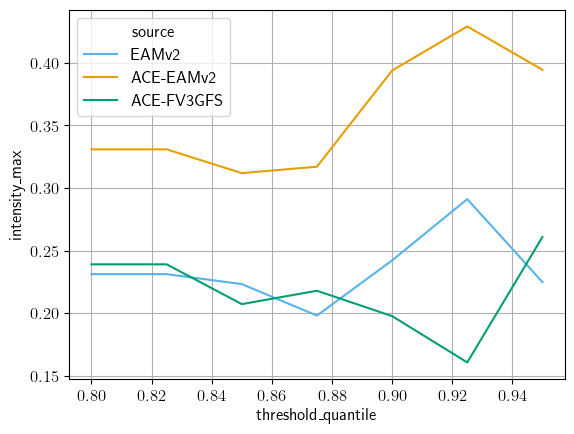

In [275]:
cols = ["threshold_quantile", "intensity_max", "source"]

df_to_plot = mjo_props_df[cols].groupby(["threshold_quantile", "source"]).mean("intensity_max")
sns.lineplot(df_to_plot, x="threshold_quantile", y="intensity_max", hue="source", hue_order=list(reversed(labels.values())))
plt.grid()
plt.show()